### Using Polar and Log-Polar Transformations for Registration
[link to example](https://scikit-image.org/docs/stable/auto_examples/registration/plot_register_rotation.html#sphx-glr-auto-examples-registration-plot-register-rotation-py)

Phase correlation (`registration.phase_correlation`) is an efficient method for determining translation offset between pairs of similar images. However this approach telies on a near absence of rotation/scaling diffrences between the images, which are typical in real-world examples.

To recover rotation and scaling diffrences between two images, we can take advantage of two geometric properties of the log-polar transform and the translation invariance of the frequency domain. First, rotation in Cartesian space becomes translation along the angular cooridinate ($ \theta $) axis log-polar space. Second, scaling in Cartesian space becomes translation along the radial coordinate ($ \rho = \ln{\sqrt{x^2+y^2}}$) of log-polar space. Finally, differences in translation in the spatial domain do not impact magnitude spectrum in the frequency domain.

In this series of examples, we build on these concepts to show how the log-polar transform `transform.wrap_polar` can be used in conjunction with phase correlation to recover rotation and scaling diffrences between two images that also have a translation offset.

#### Recover rotation difference with a polar transform

In first example, we consider the simple case of two images that only differ with respect to rotation around a common center point. By remapping these images into polar space, the rotation difference becomes a simple translation difference that can be recovered by phase correlation.

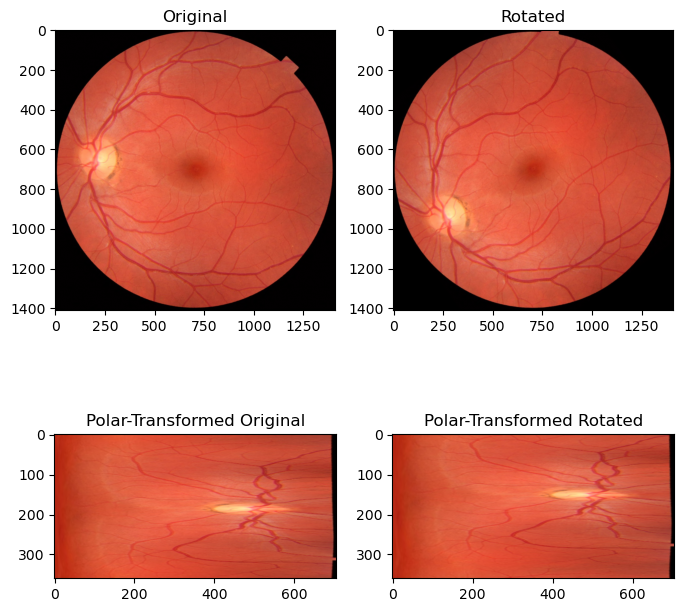

Expected value for counterclockwise rotation in degrees: 35
Recovered value for counterclockwise rotation: 35.0


In [4]:
import numpy as np
import matplotlib.pyplot as plt

from skimage import data
from skimage.registration import phase_cross_correlation
from skimage.transform import warp_polar, rotate, rescale
from skimage.util import img_as_float

radius = 705
angle = 35
image = img_as_float(data.retina())
rotated = rotate(image, angle)
image_polar = warp_polar(image, radius=radius, channel_axis=-1)
rotated_polar = warp_polar(rotated, radius=radius, channel_axis=-1)

fig, axes = plt.subplots(2, 2, figsize=(8,8))
ax = axes.ravel()
ax[0].set_title("Original")
ax[0].imshow(image)
ax[1].set_title("Rotated")
ax[1].imshow(rotated)
ax[2].set_title("Polar-Transformed Original")
ax[2].imshow(image_polar)
ax[3].set_title("Polar-Transformed Rotated")
ax[3].imshow(rotated_polar)
plt.show()

shifts, error, phasediff = phase_cross_correlation(image_polar, rotated_polar)
print(f"Expected value for counterclockwise rotation in degrees: {angle}")
print(f"Recovered value for counterclockwise rotation: {shifts[0]}")